# Benchmark perturbation prediction performance

#### Notebooks for comparison perturbation prediction

## Library imports

In [1]:
import scipy
import numpy as np
import pandas as pd
import scanpy as sc
import scvelo as scv

import matplotlib.pyplot as plt
import mplscience
import seaborn as sns

from rgv_tools import DATA_DIR, FIG_DIR

/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/regvelo_t

## Define functions

In [2]:
def perturb_prediction(coef,perturbation,gene_list):
    
    gt = perturbation.loc[[i in coef.index for i in perturbation.loc[:,"sgRNA_group"]],:].copy()
    gt = gt.loc[[i in ["Pigment_gch2_high","mNC_hox34","mNC_arch2","mNC_head_mesenchymal"] for i in gt.loc[:,"cell_anno"]],:]
    
    ## zero-center the likelihood of different panel.
    for tf in gene_list:
        gt.loc[[i in tf for i in gt.loc[:,"sgRNA_group"]],"median_likelihood"] = gt.loc[[i in tf for i in gt.loc[:,"sgRNA_group"]],"median_likelihood"] - np.mean(gt.loc[[i in tf for i in gt.loc[:,"sgRNA_group"]],"median_likelihood"])
        
    terminal_states = ["Pigment","mNC_hox34","mNC_arch2","mNC_head_mesenchymal"]
    coef = coef.loc[:,terminal_states]
    coef.columns = ["Pigment_gch2_high","mNC_hox34","mNC_arch2","mNC_head_mesenchymal"]
    pred_effect = []
    TF = []
    for i in range(gt.shape[0]):
        ts = gt.iloc[i,0]
        tf = gt.iloc[i,2]
        effect = coef.loc[tf,ts]
        pred_effect.append(effect)
        TF.append(tf)
    pred = pd.DataFrame({"TF":TF,"effect":pred_effect})
    return scipy.stats.spearmanr(pred.iloc[:,1], gt.iloc[:,1])[0]

## General setting

In [3]:
plt.rcParams['svg.fonttype'] = 'none'
sns.reset_defaults()
sns.reset_orig()
scv.settings.set_figure_params('scvelo', dpi_save=400, dpi=80, transparent=True, fontsize=14, color_map='viridis')

## Constants

In [4]:
DATASET = "zebrafish"

SAVE_FIGURES = True
if SAVE_FIGURES:
    (FIG_DIR / DATASET).mkdir(parents=True, exist_ok=True)

## Loading dataset

### single knock-out

#### Loading ground truth

In [5]:
gene_list = ['elk3',
     'erf',
     'etv2',
     'fli1a',
     'mitfa',
     'nr2f5',
     'rarga',
     'rxraa',
     'smarcc1a',
     'tfec',
     'nr2f2']
perturbation = pd.read_csv(DATA_DIR / DATASET / "raw" / "df_median_meld_likelihood_new.csv")

#### predict perturbation

In [6]:
coef_perturb_co = pd.read_csv(DATA_DIR / DATASET / "results" / "celloracle_perturb_single.csv",index_col = 0)
coef_perturb_dyn = pd.read_csv(DATA_DIR / DATASET / "results" / "dynamo_perturb_single.csv",index_col = 0)
coef_KO_dyn = pd.read_csv(DATA_DIR / DATASET / "results" / "dynamo_KO_single.csv",index_col = 0)

In [7]:
score_s = []
method = []

score_s.append(perturb_prediction(1 - coef_perturb_co,perturbation,gene_list))
method.append("celloracle")

score_s.append(perturb_prediction(coef_perturb_dyn,perturbation,gene_list))
method.append("Dynamo(perturbation)")

score_s.append(perturb_prediction(1 - coef_KO_dyn,perturbation,gene_list))
method.append("Dynamo(KO)")

In [8]:
for nrun in range(3):
    coef_perturb_rgv = pd.read_csv(DATA_DIR / DATASET / "results" / f"coef_single_regvelo_{nrun}",index_col = 0)
    score_s.append(perturb_prediction(1 - coef_perturb_rgv,perturbation,gene_list))
    method.append("RegVelo")

### multiple knock-out

In [9]:
gene_list = ["fli1a_elk3","mitfa_tfec","tfec_mitfa_bhlhe40","fli1a_erf_erfl3","erf_erfl3"]

#### predict perturbation

In [10]:
coef_perturb_co = pd.read_csv(DATA_DIR / DATASET / "results" / "celloracle_perturb_multiple.csv",index_col = 0)
coef_perturb_dyn = pd.read_csv(DATA_DIR / DATASET / "results" / "dynamo_perturb_multiple.csv",index_col = 0)
coef_KO_dyn = pd.read_csv(DATA_DIR / DATASET / "results" / "dynamo_KO_multiple.csv",index_col = 0)

In [11]:
score_m = []
method = []

score_m.append(perturb_prediction(1 - coef_perturb_co,perturbation,gene_list))
method.append("celloracle")

score_m.append(perturb_prediction(coef_perturb_dyn,perturbation,gene_list))
method.append("Dynamo(perturbation)")

score_m.append(perturb_prediction(1 - coef_KO_dyn,perturbation,gene_list))
method.append("Dynamo(KO)")

In [12]:
for nrun in range(3):
    coef_perturb_rgv = pd.read_csv(DATA_DIR / DATASET / "results" / f"coef_multiple_regvelo_{nrun}",index_col = 0)
    score_m.append(perturb_prediction(1 - coef_perturb_rgv,perturbation,gene_list))
    method.append("RegVelo")

## Plot benchmark results

In [13]:
dat = pd.DataFrame({"spearman_correlation": score_s,
                    "method": method})
dat2 = pd.DataFrame({"spearman_correlation": score_m,
                    "method": method})
dat["Experimental class"] = "Single TF knock-out"
dat2["Experimental class"] = "Multiple TF knock-out"
df = pd.concat([dat, dat2], axis=0)

In [14]:
colors = [(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451)]

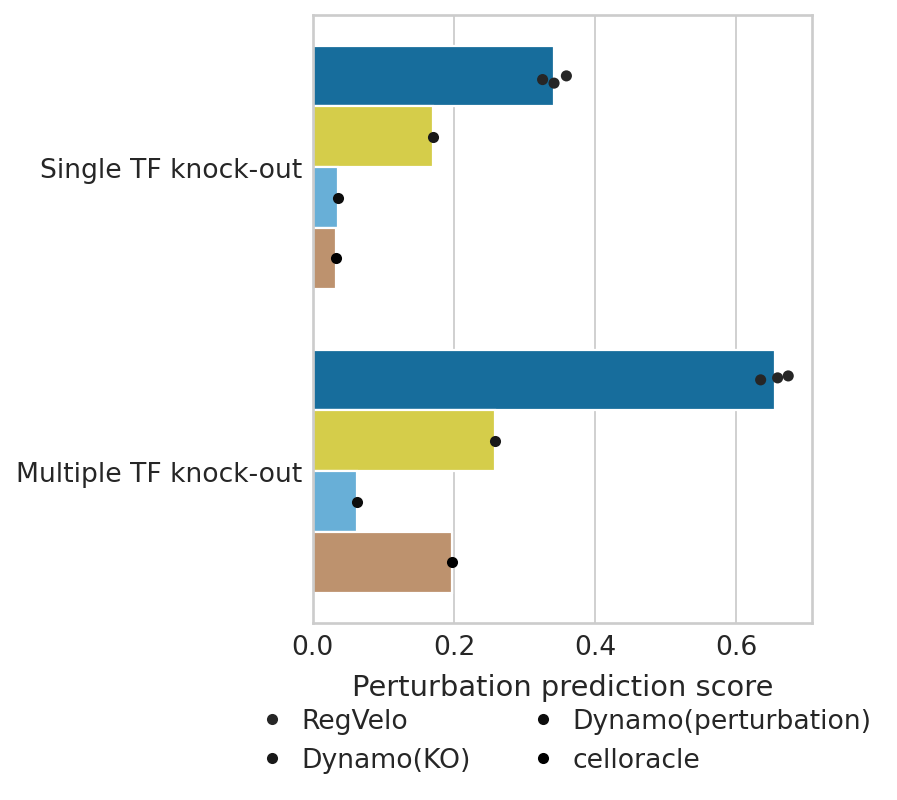

In [15]:
order = ["RegVelo","Dynamo(KO)","Dynamo(perturbation)","celloracle"]
with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(4, 5))

    # Plot the barplot without error bars
    sns.barplot(data=df, y="Experimental class", x="spearman_correlation", hue="method", hue_order = order, palette=colors, ax=ax, ci=None)

    # Add jittered dots
    sns.stripplot(data=df, y="Experimental class", x="spearman_correlation", hue="method", hue_order = order, dodge=True, color="black", ax=ax, jitter=True)

    # Remove the duplicate legend
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[4:(4+len(colors))], labels[4:(4+len(colors))], bbox_to_anchor=(0.5, -0.1), loc='upper center', ncol=2)

    # Customize labels and other settings
    ax.set(ylabel='', xlabel='Perturbation prediction score')
    ax.set_xlabel(xlabel='Perturbation prediction score', fontsize=13)
    
    if SAVE_FIGURES:
        plt.savefig(FIG_DIR / DATASET / 'barplot_joint_knockout_update.svg',
                    format="svg",
                    transparent=True,
                    bbox_inches='tight')
    plt.show()

## Comparison

In [16]:
fc = score_s[3:] / score_s[2]
scipy.stats.ttest_ind(fc,fc*0,equal_var=False, alternative="greater")

TtestResult(statistic=35.15253816810182, pvalue=0.00040413813606890626, df=2.0)

In [17]:
fc = score_m[3:] / score_m[2]
scipy.stats.ttest_ind(fc,fc*0,equal_var=False, alternative="greater")

TtestResult(statistic=57.581489273695844, pvalue=0.0001507328102453564, df=2.0)

## Reason why pick gch2-high pigment cells

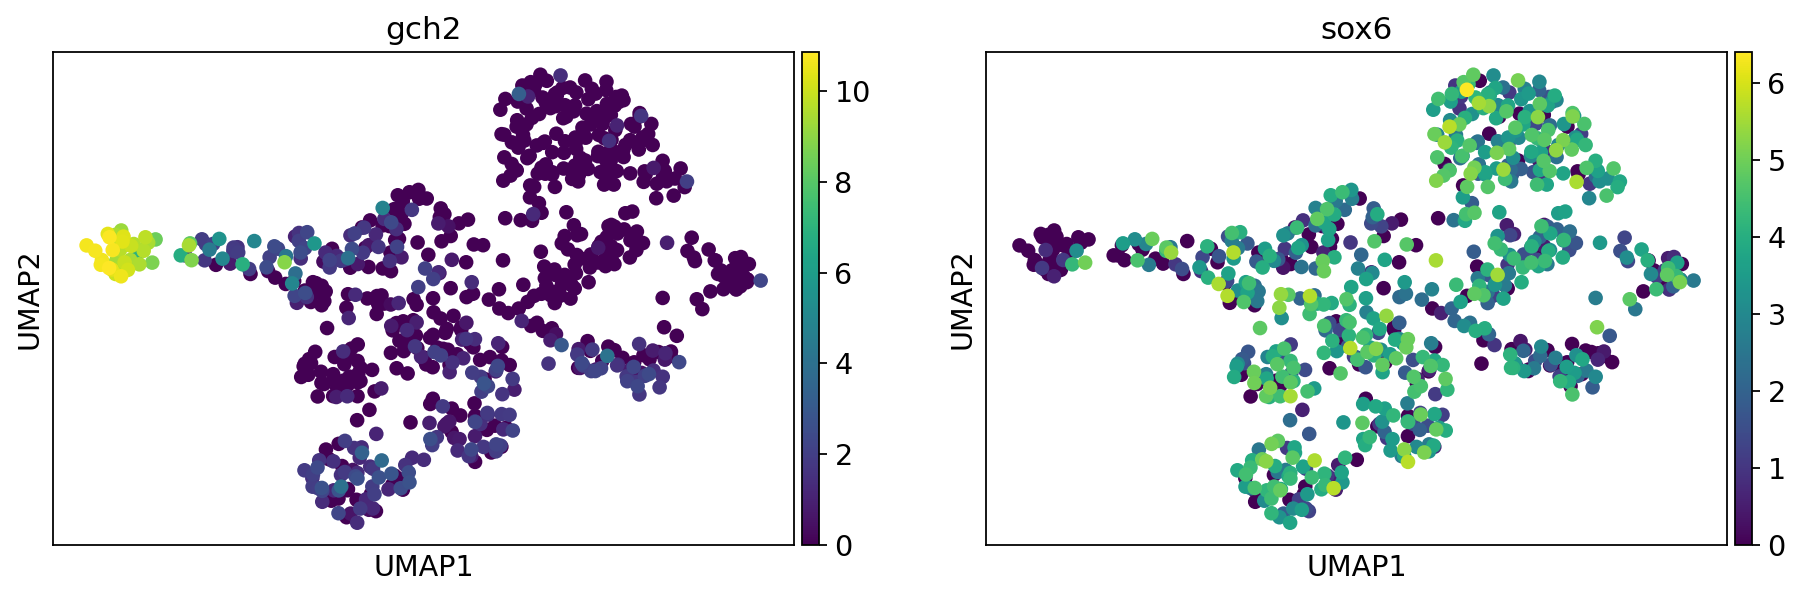

In [18]:
adata = sc.read_h5ad(DATA_DIR / DATASET / "processed" / "adata_preprocessed.h5ad")
sc.pl.umap(adata, color=["gch2","sox6"])